## Training for Synth Paper 2022

### Loading data

In [1]:
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import timm

import albumentations as albu
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# helper function for data visualization
def visualize(label, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        plt.title(f'{name.title()} | GT: {label}')
        plt.imshow(image)
    plt.show()

### Data Preparation

In [4]:
df = pd.read_csv('synth_paper_data.csv')
df['class'] = df['class'].astype('category')

In [5]:
df.sample(5)

,file_path,file_name,source,split,class,label_encoded
34373,../../data/Covidx/data_with_classes/train/norm...,5699df0c-aa5a-4109-8f23-1bed85d1470e.png,Covidx,train,H,3
6967,../../data/generated_data/cs_uu/nb/sample_9341...,sample_9341.png,Synth,train,H,3
22562,../../data/Covidx/data_with_classes/train/norm...,91b8532d-9a47-4ed1-841b-ea4091f1db8c.png,Covidx,train,H,3
7056,../../data/generated_data/cs_uu/nb/sample_4867...,sample_4867.png,Synth,train,H,3
24887,../../data/Covidx/data_with_classes/train/norm...,b55db584-960a-4816-ba8b-b7fb493455ac.png,Covidx,train,H,3


In [6]:
df['source'].unique()

array(['UKU_old_split', 'UKU_all', 'Synth', 'Covidx'], dtype=object)

In [7]:
df.loc[df['source']=='UKU_all','class'].value_counts()

H    673
F    125
C    110
B    100
V     74
Name: class, dtype: int64

In [8]:
df_uku_binary = df.loc[df['source']=='UKU_all'].copy()

In [9]:
cls_map = {'C' : 'P',
           'H' : 'H',
           'V' : 'P',
           'F' : 'P',
           'B' : 'P'}

In [10]:
df_uku_binary['class'] = df_uku_binary['class'].map(cls_map)

In [11]:
df_uku_binary['class'] = df_uku_binary['class'].astype('category')
df_uku_binary['label_encoded'] = df_uku_binary['class'].cat.codes.astype('int64')

In [12]:
df_uku_binary['split'].value_counts()

train    865
test     217
Name: split, dtype: int64

In [13]:
pd.pivot_table(df_uku_binary,values=['file_name'],index=['split'],columns=['class'],aggfunc='count')

file_name     
class         H    P
split               
test        135   82
train       538  327

In [14]:
df_uku_binary.head()

,file_path,file_name,source,split,class,label_encoded
333,../../data/segmentation_test/raw/C59.png,C59.png,UKU_all,train,P,1
334,../../data/segmentation_test/raw/NB46.png,NB46.png,UKU_all,train,H,0
335,../../data/segmentation_test/raw/NB663.png,NB663.png,UKU_all,train,H,0
336,../../data/segmentation_test/raw/V29.png,V29.png,UKU_all,train,P,1
337,../../data/segmentation_test/raw/NB626.png,NB626.png,UKU_all,train,H,0


Split on patients to avoid overlap:

In [126]:
patients = pd.read_csv('../../data/segmentation_test/image_details_full.csv')

In [127]:
df_uku_binary_patients = pd.merge(df_uku_binary,patients,on='file_name')

In [128]:
df_uku_binary_patients.drop('class_y',axis=1,inplace=True)
df_uku_binary_patients.rename(columns={'class_x':'class'},inplace=True)

In [130]:
train_pat_ids, valid_pat_ids = train_test_split(df_uku_binary_patients['patient_id'].unique(),test_size=0.2, random_state=14)

In [131]:
df_uku_binary_patients['patient_id'].isin(train_pat_ids).value_counts()

True     867
False    215
Name: patient_id, dtype: int64

In [132]:
df_uku_binary_patients['split'].value_counts()

train    865
test     217
Name: split, dtype: int64

In [133]:
df_uku_binary_patients.loc[df_uku_binary_patients['patient_id'].isin(train_pat_ids),'class'].value_counts()/len(df_uku_binary_patients)

H    0.489834
P    0.311460
Name: class, dtype: float64

In [134]:
df_uku_binary_patients['class'].value_counts()/len(df_uku_binary_patients)

H    0.621996
P    0.378004
Name: class, dtype: float64

In [135]:
df_uku_binary_patients.loc[df_uku_binary_patients['patient_id'].isin(train_pat_ids),'patient_split'] = 'train'

In [136]:
df_uku_binary_patients.loc[df_uku_binary_patients['patient_id'].isin(valid_pat_ids),'patient_split'] = 'valid'

In [137]:
df_uku_binary_patients.head()

,file_path,file_name,source,split,class,label_encoded,patient_id,patient_split
0,../../data/segmentation_test/raw/C59.png,C59.png,UKU_all,train,P,1,C57,train
1,../../data/segmentation_test/raw/NB46.png,NB46.png,UKU_all,train,H,0,NB46,valid
2,../../data/segmentation_test/raw/NB663.png,NB663.png,UKU_all,train,H,0,NB663,train
3,../../data/segmentation_test/raw/V29.png,V29.png,UKU_all,train,P,1,V23,train
4,../../data/segmentation_test/raw/NB626.png,NB626.png,UKU_all,train,H,0,NB626,train


Dataloader:

In [15]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations."""
    
    def __init__(
            self,
            df, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.df = df.reset_index(drop=True)
        self.ids = self.df.loc[:,'file_path'].values
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.ids[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        
        label = self.df.loc[i,'label_encoded']
        
        return image, label
        
    def __len__(self):
        return len(self.ids)

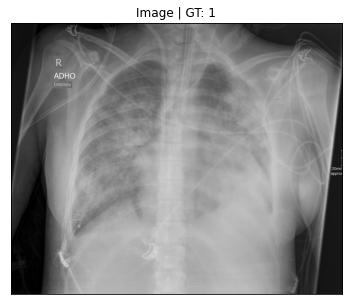

In [16]:
dataset = Dataset(df_uku_binary)

image, label = dataset[3] # get some sample
visualize(
    label=label,
    image=image
)

### Augmentations

In [17]:
image_size = 224

In [18]:
def get_training_augmentation():
    train_transform = [
        
        albu.RandomResizedCrop(height=image_size, width=image_size, scale=(0.25, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1, p=1.0),
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),


        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(384, 480)
        albu.Resize(image_size, image_size),
        #albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD,max_pixel_value=255.0),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

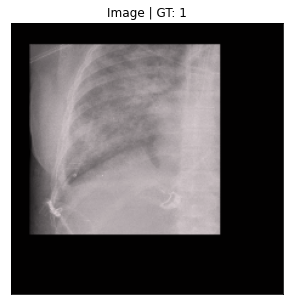

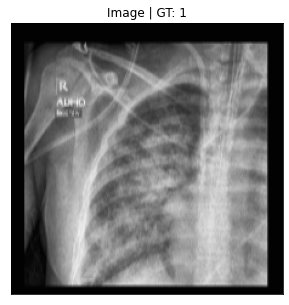

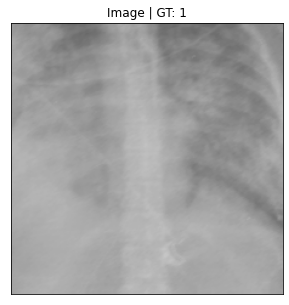

In [19]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    df_uku_binary, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, label = augmented_dataset[3]
    visualize(label=label,image=image)

### Create model and train

Define model

In [20]:
dropout = False
dropout_percent = 0.5
num_classes = 2

In [21]:
model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
num_ftrs = model.get_classifier().in_features
if dropout:
    model.fc = nn.Sequential(
                            nn.Dropout(dropout_percent),
                            nn.Linear(num_ftrs,num_classes)
    )
else:
    model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device) 

Define Loss function and optimizer

In [22]:
epochs = 40
val_loss_min = np.Inf

In [23]:
criterion = nn.CrossEntropyLoss()

In [24]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs-1)

scaler = torch.cuda.amp.GradScaler()

In [25]:
train_dataset = Dataset(
    df_uku_binary.loc[df_uku_binary['split']=='train',:],
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing()
)

valid_dataset = Dataset(
    df_uku_binary.loc[df_uku_binary['split']=='test',:], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [26]:
ckpt_dir = './models'
CHECKPOINT = f'{ckpt_dir}/resnet50_synth_uku_all_binary.pth'

In [27]:
for epoch in range(epochs):
    model.train()
    train_loss = []
    train_running_corrects = 0
    val_running_corrects = 0
    
    loop = tqdm(train_loader)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            train_loss.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            #_,labels = torch.max(labels.data, 1)
            train_running_corrects += torch.sum(predicted == labels.data)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()

        loop.set_description('Epoch {:02d}/{:02d} | LR: {:.5f}'.format(epoch, epochs-1, optimizer.param_groups[0]['lr']))
        loop.set_postfix(loss=np.mean(train_loss))

    train_loss = np.mean(train_loss)
    train_epoch_acc = train_running_corrects.double() / len(train_loader.dataset)
    
    model.eval()

    val_loss = 0

    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast(), torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            #_,labels = torch.max(labels.data, 1)
            val_running_corrects += torch.sum(predicted == labels.data)

    val_loss /= len(valid_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(valid_loader.dataset)
    
    print(f'train loss: {train_loss:.5f} | train acc: {train_epoch_acc:.3f} | val_loss: {val_loss:.5f} | val acc: {val_epoch_acc:.3f}')
    
    if val_loss < val_loss_min:
            print(f'Valid loss improved from {val_loss_min:.5f} to {val_loss:.5f} saving model to {CHECKPOINT}')
            val_loss_min = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), CHECKPOINT)
    
    print(f'Best epoch {best_epoch} | val loss min: {val_loss_min:.5f}')

  0%|          | 0/55 [00:00<?, ?it/s]/data/DS/miniconda3/envs/pytorch_seg/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 00/39 | LR: 0.00004: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s, loss=0.421]
100%|██████████| 217/217 [00:07<00:00, 27.38it/s]


train loss: 0.42079 | train acc: 0.802 | val_loss: 0.17476 | val acc: 0.917
Valid loss improved from inf to 0.17476 saving model to ./models/resnet18_synth_uku_all_binary.pth
Best epoch 0 | val loss min: 0.17476


Epoch 01/39 | LR: 0.00001: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s, loss=0.336]
100%|██████████| 217/217 [00:08<00:00, 27.00it/s]


train loss: 0.33612 | train acc: 0.868 | val_loss: 0.24108 | val acc: 0.894
Best epoch 0 | val loss min: 0.17476


Epoch 02/39 | LR: 0.00009: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s, loss=0.267]
100%|██████████| 217/217 [00:07<00:00, 27.67it/s]


train loss: 0.26701 | train acc: 0.887 | val_loss: 0.24465 | val acc: 0.922
Best epoch 0 | val loss min: 0.17476


Epoch 03/39 | LR: 0.00007: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s, loss=0.311]
100%|██████████| 217/217 [00:07<00:00, 27.45it/s]


train loss: 0.31115 | train acc: 0.892 | val_loss: 0.09297 | val acc: 0.959
Valid loss improved from 0.17476 to 0.09297 saving model to ./models/resnet18_synth_uku_all_binary.pth
Best epoch 3 | val loss min: 0.09297


Epoch 04/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s, loss=0.278]
100%|██████████| 217/217 [00:07<00:00, 27.21it/s]


train loss: 0.27846 | train acc: 0.891 | val_loss: 0.10658 | val acc: 0.963
Best epoch 3 | val loss min: 0.09297


Epoch 05/39 | LR: 0.00006: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s, loss=0.259]
100%|██████████| 217/217 [00:07<00:00, 27.31it/s]


train loss: 0.25908 | train acc: 0.906 | val_loss: 0.10673 | val acc: 0.968
Best epoch 3 | val loss min: 0.09297


Epoch 06/39 | LR: 0.00010: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s, loss=0.231]
100%|██████████| 217/217 [00:07<00:00, 27.19it/s]


train loss: 0.23096 | train acc: 0.902 | val_loss: 0.09702 | val acc: 0.963
Best epoch 3 | val loss min: 0.09297


Epoch 07/39 | LR: 0.00002: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s, loss=0.264]
100%|██████████| 217/217 [00:07<00:00, 27.65it/s]


train loss: 0.26354 | train acc: 0.899 | val_loss: 0.14276 | val acc: 0.945
Best epoch 3 | val loss min: 0.09297


Epoch 08/39 | LR: 0.00002: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s, loss=0.267]
100%|██████████| 217/217 [00:07<00:00, 27.43it/s]


train loss: 0.26674 | train acc: 0.901 | val_loss: 0.09309 | val acc: 0.972
Best epoch 3 | val loss min: 0.09297


Epoch 09/39 | LR: 0.00010: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s, loss=0.23] 
100%|██████████| 217/217 [00:07<00:00, 27.40it/s]


train loss: 0.22997 | train acc: 0.918 | val_loss: 0.08871 | val acc: 0.982
Valid loss improved from 0.09297 to 0.08871 saving model to ./models/resnet18_synth_uku_all_binary.pth
Best epoch 9 | val loss min: 0.08871


Epoch 10/39 | LR: 0.00005: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s, loss=0.247]
100%|██████████| 217/217 [00:07<00:00, 27.39it/s]


train loss: 0.24700 | train acc: 0.905 | val_loss: 0.08110 | val acc: 0.972
Valid loss improved from 0.08871 to 0.08110 saving model to ./models/resnet18_synth_uku_all_binary.pth
Best epoch 10 | val loss min: 0.08110


Epoch 11/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s, loss=0.242]
100%|██████████| 217/217 [00:07<00:00, 27.28it/s]


train loss: 0.24162 | train acc: 0.904 | val_loss: 0.07688 | val acc: 0.972
Valid loss improved from 0.08110 to 0.07688 saving model to ./models/resnet18_synth_uku_all_binary.pth
Best epoch 11 | val loss min: 0.07688


Epoch 12/39 | LR: 0.00007: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s, loss=0.199]
100%|██████████| 217/217 [00:08<00:00, 27.02it/s]


train loss: 0.19950 | train acc: 0.926 | val_loss: 0.07401 | val acc: 0.972
Valid loss improved from 0.07688 to 0.07401 saving model to ./models/resnet18_synth_uku_all_binary.pth
Best epoch 12 | val loss min: 0.07401


Epoch 13/39 | LR: 0.00008: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s, loss=0.21] 
100%|██████████| 217/217 [00:07<00:00, 27.41it/s]


train loss: 0.20970 | train acc: 0.927 | val_loss: 0.08242 | val acc: 0.972
Best epoch 12 | val loss min: 0.07401


Epoch 14/39 | LR: 0.00001: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s, loss=0.224]
100%|██████████| 217/217 [00:07<00:00, 27.54it/s]


train loss: 0.22412 | train acc: 0.919 | val_loss: 0.05878 | val acc: 0.986
Valid loss improved from 0.07401 to 0.05878 saving model to ./models/resnet18_synth_uku_all_binary.pth
Best epoch 14 | val loss min: 0.05878


Epoch 15/39 | LR: 0.00004: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s, loss=0.206]
100%|██████████| 217/217 [00:07<00:00, 27.40it/s]


train loss: 0.20597 | train acc: 0.928 | val_loss: 0.06798 | val acc: 0.982
Best epoch 14 | val loss min: 0.05878


Epoch 16/39 | LR: 0.00010: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s, loss=0.187]
100%|██████████| 217/217 [00:07<00:00, 27.40it/s]


train loss: 0.18657 | train acc: 0.932 | val_loss: 0.08691 | val acc: 0.972
Best epoch 14 | val loss min: 0.05878


Epoch 17/39 | LR: 0.00003: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s, loss=0.22] 
100%|██████████| 217/217 [00:07<00:00, 27.43it/s]


train loss: 0.21966 | train acc: 0.932 | val_loss: 0.16189 | val acc: 0.954
Best epoch 14 | val loss min: 0.05878


Epoch 18/39 | LR: 0.00001: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s, loss=0.183]
100%|██████████| 217/217 [00:07<00:00, 27.26it/s]


train loss: 0.18290 | train acc: 0.924 | val_loss: 0.10752 | val acc: 0.959
Best epoch 14 | val loss min: 0.05878


Epoch 19/39 | LR: 0.00009: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s, loss=0.179]
100%|██████████| 217/217 [00:07<00:00, 27.37it/s]


train loss: 0.17903 | train acc: 0.933 | val_loss: 0.09394 | val acc: 0.963
Best epoch 14 | val loss min: 0.05878


Epoch 20/39 | LR: 0.00007: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s, loss=0.216]
100%|██████████| 217/217 [00:07<00:00, 27.22it/s]


train loss: 0.21581 | train acc: 0.919 | val_loss: 0.06400 | val acc: 0.968
Best epoch 14 | val loss min: 0.05878


Epoch 21/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s, loss=0.165]
100%|██████████| 217/217 [00:07<00:00, 27.44it/s]


train loss: 0.16505 | train acc: 0.935 | val_loss: 0.06443 | val acc: 0.982
Best epoch 14 | val loss min: 0.05878


Epoch 22/39 | LR: 0.00006: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s, loss=0.186]
100%|██████████| 217/217 [00:08<00:00, 27.01it/s]


train loss: 0.18560 | train acc: 0.934 | val_loss: 0.11652 | val acc: 0.963
Best epoch 14 | val loss min: 0.05878


Epoch 23/39 | LR: 0.00009: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s, loss=0.252]
100%|██████████| 217/217 [00:07<00:00, 27.39it/s]


train loss: 0.25178 | train acc: 0.916 | val_loss: 0.09552 | val acc: 0.968
Best epoch 14 | val loss min: 0.05878


Epoch 24/39 | LR: 0.00002: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s, loss=0.188]
100%|██████████| 217/217 [00:07<00:00, 27.29it/s]


train loss: 0.18767 | train acc: 0.929 | val_loss: 0.07563 | val acc: 0.963
Best epoch 14 | val loss min: 0.05878


Epoch 25/39 | LR: 0.00002: 100%|██████████| 55/55 [00:12<00:00,  4.35it/s, loss=0.167]
100%|██████████| 217/217 [00:07<00:00, 27.86it/s]


train loss: 0.16679 | train acc: 0.932 | val_loss: 0.08121 | val acc: 0.968
Best epoch 14 | val loss min: 0.05878


Epoch 26/39 | LR: 0.00010: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s, loss=0.2]  
100%|██████████| 217/217 [00:07<00:00, 27.69it/s]


train loss: 0.19962 | train acc: 0.939 | val_loss: 0.12795 | val acc: 0.959
Best epoch 14 | val loss min: 0.05878


Epoch 27/39 | LR: 0.00005: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s, loss=0.179]
100%|██████████| 217/217 [00:07<00:00, 27.82it/s]


train loss: 0.17893 | train acc: 0.929 | val_loss: 0.11149 | val acc: 0.963
Best epoch 14 | val loss min: 0.05878


Epoch 28/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s, loss=0.173]
100%|██████████| 217/217 [00:07<00:00, 27.99it/s]


train loss: 0.17273 | train acc: 0.947 | val_loss: 0.06321 | val acc: 0.982
Best epoch 14 | val loss min: 0.05878


Epoch 29/39 | LR: 0.00008: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s, loss=0.157]
100%|██████████| 217/217 [00:07<00:00, 27.81it/s]


train loss: 0.15708 | train acc: 0.945 | val_loss: 0.06206 | val acc: 0.977
Best epoch 14 | val loss min: 0.05878


Epoch 30/39 | LR: 0.00008: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s, loss=0.193]
100%|██████████| 217/217 [00:07<00:00, 27.79it/s]


train loss: 0.19335 | train acc: 0.936 | val_loss: 0.10944 | val acc: 0.963
Best epoch 14 | val loss min: 0.05878


Epoch 31/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s, loss=0.153] 
100%|██████████| 217/217 [00:07<00:00, 27.26it/s]


train loss: 0.15327 | train acc: 0.950 | val_loss: 0.10721 | val acc: 0.963
Best epoch 14 | val loss min: 0.05878


Epoch 32/39 | LR: 0.00004: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s, loss=0.173]
100%|██████████| 217/217 [00:07<00:00, 27.62it/s]


train loss: 0.17276 | train acc: 0.936 | val_loss: 0.10273 | val acc: 0.968
Best epoch 14 | val loss min: 0.05878


Epoch 33/39 | LR: 0.00010: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s, loss=0.14] 
100%|██████████| 217/217 [00:07<00:00, 27.82it/s]


train loss: 0.14037 | train acc: 0.943 | val_loss: 0.06572 | val acc: 0.977
Best epoch 14 | val loss min: 0.05878


Epoch 34/39 | LR: 0.00003: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s, loss=0.166]
100%|██████████| 217/217 [00:07<00:00, 27.84it/s]


train loss: 0.16552 | train acc: 0.949 | val_loss: 0.07875 | val acc: 0.963
Best epoch 14 | val loss min: 0.05878


Epoch 35/39 | LR: 0.00001: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s, loss=0.155] 
100%|██████████| 217/217 [00:07<00:00, 27.91it/s]


train loss: 0.15549 | train acc: 0.942 | val_loss: 0.07254 | val acc: 0.959
Best epoch 14 | val loss min: 0.05878


Epoch 36/39 | LR: 0.00009: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s, loss=0.141]
100%|██████████| 217/217 [00:07<00:00, 27.90it/s]


train loss: 0.14133 | train acc: 0.958 | val_loss: 0.14111 | val acc: 0.959
Best epoch 14 | val loss min: 0.05878


Epoch 37/39 | LR: 0.00006: 100%|██████████| 55/55 [00:12<00:00,  4.35it/s, loss=0.159]
100%|██████████| 217/217 [00:07<00:00, 27.84it/s]


train loss: 0.15889 | train acc: 0.943 | val_loss: 0.07746 | val acc: 0.968
Best epoch 14 | val loss min: 0.05878


Epoch 38/39 | LR: 0.00000: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s, loss=0.195]
100%|██████████| 217/217 [00:07<00:00, 27.78it/s]


train loss: 0.19539 | train acc: 0.942 | val_loss: 0.09235 | val acc: 0.968
Best epoch 14 | val loss min: 0.05878


Epoch 39/39 | LR: 0.00006: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s, loss=0.157]
100%|██████████| 217/217 [00:07<00:00, 27.71it/s]

train loss: 0.15651 | train acc: 0.945 | val_loss: 0.10467 | val acc: 0.959
Best epoch 14 | val loss min: 0.05878


### Visualize predictions

In [29]:
model_inf = timm.create_model('resnet18', pretrained=True, num_classes=num_classes)
num_ftrs = model_inf.get_classifier().in_features
if dropout:
    model_inf.fc = nn.Sequential(
                            nn.Dropout(dropout_percent),
                            nn.Linear(num_ftrs,num_classes)
    )
else:
    model_inf.fc = nn.Linear(num_ftrs, num_classes)

model_inf.load_state_dict(torch.load(CHECKPOINT))
model_inf.to(device) 
model_inf = model_inf.eval()

In [30]:
valid_dataset = Dataset(
    df_uku_binary.loc[df_uku_binary['split']=='test',:], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

#### Validation data

In [31]:
# For confusion matrix
label_array = np.array([], dtype='int64')
prediction_array = np.array([], dtype='int64')

In [32]:
with torch.no_grad():
    model_inf.eval()
    for images, labels in valid_dataset:
        images = torch.from_numpy(images).to(device).unsqueeze(0)
        #labels = labels.to(device)
        
        cls_outputs = model_inf(images)
        _, predicted = torch.max(cls_outputs.data, 1)
        #_,labels = torch.max(labels.data, 0)
        label_array = np.append(label_array, labels)
        prediction_array = np.append(prediction_array, predicted.detach().cpu().numpy())

In [33]:
%matplotlib inline

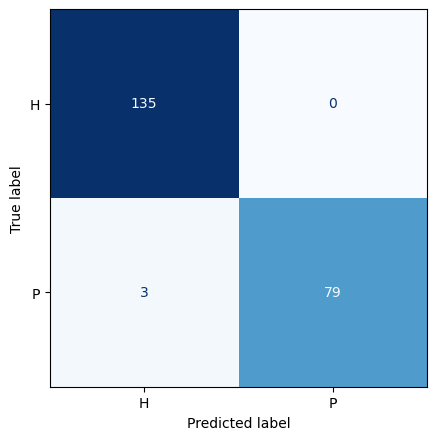

In [34]:
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
ConfusionMatrixDisplay.from_predictions(label_array,prediction_array,display_labels=['H','P'],cmap='Blues',colorbar=False,ax=ax)
plt.show()

In [35]:
print(classification_report(label_array, prediction_array, digits=4,target_names=['H','P']))

              precision    recall  f1-score   support

           H     0.9783    1.0000    0.9890       135
           P     1.0000    0.9634    0.9814        82

    accuracy                         0.9862       217
   macro avg     0.9891    0.9817    0.9852       217
weighted avg     0.9865    0.9862    0.9861       217

